### **Importing Necessary Modules**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch

### **Load Bangle Data**

In [2]:
bangle_data = pd.read_csv("HRV-data/bangle.csv")
print(bangle_data.head())

    timestamp_ms  value
0  1724074011462   4334
1  1724074011481   4286
2  1724074011501   4222
3  1724074011520   4174
4  1724074011540   4094


### **Plot Bangle Data**

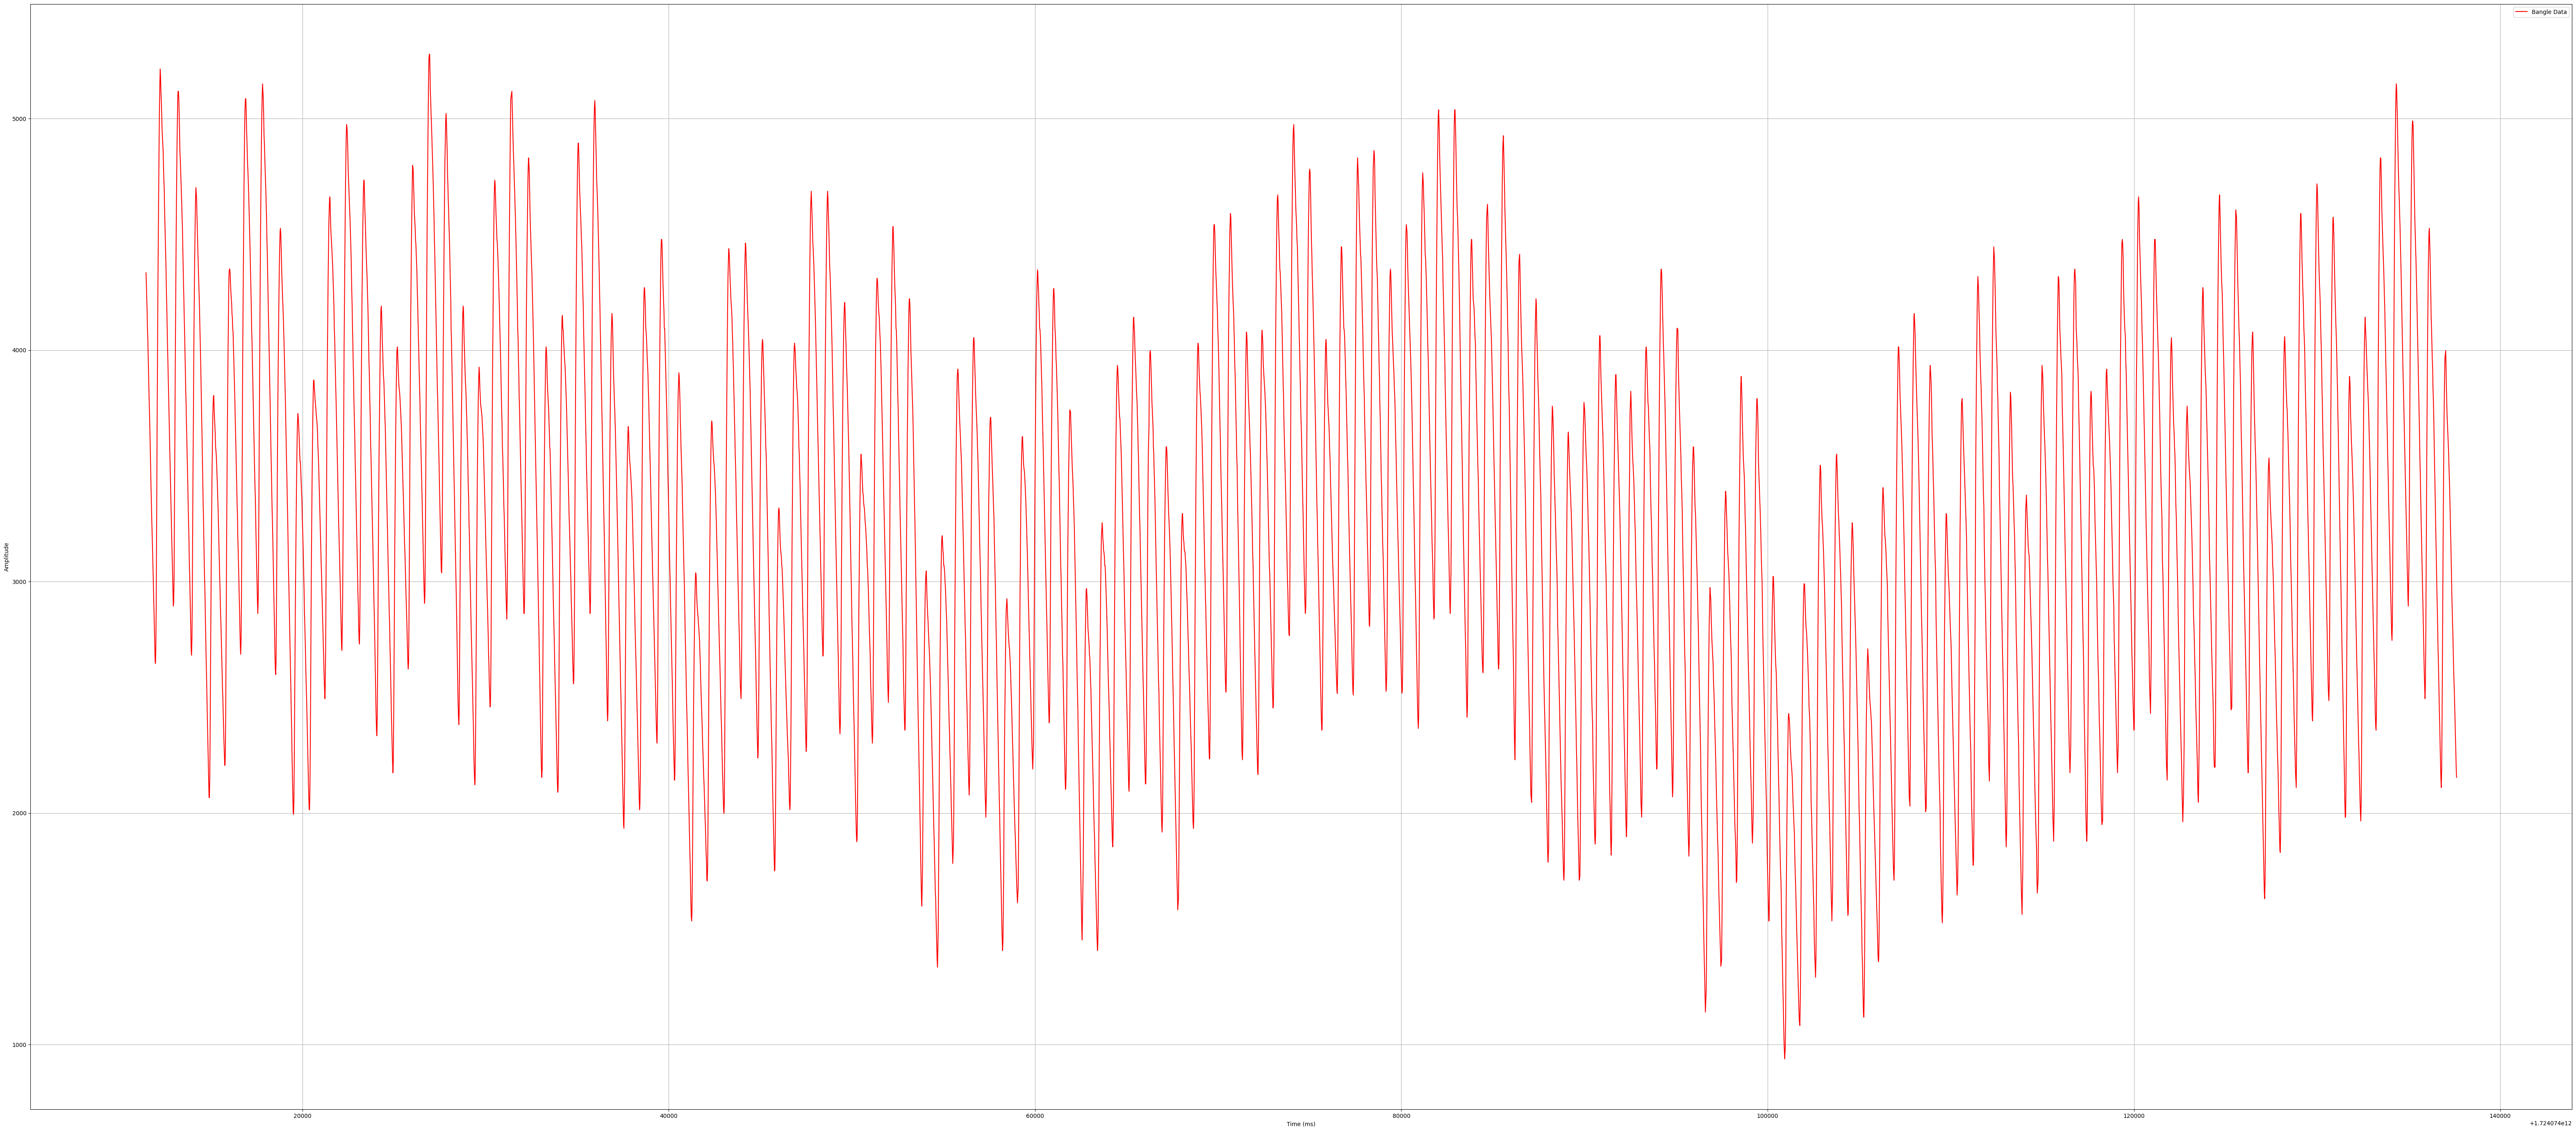

In [3]:
timestamps = bangle_data["timestamp_ms"].to_numpy()
ppg_raw = bangle_data["value"].to_numpy()

plt.figure(figsize=(80, 35))
plt.plot(timestamps, ppg_raw, c='r', label="Bangle Data")
plt.legend()
plt.grid(True, 'both', 'both')
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

### **Estimating PPG Sampling Rate For find_peaks( ) Function**
- _Higher sampling rate means more data points are captured, allowing for higher resolution of data, and greater analysis of physiological parameters_
- _Sampling frequency simply means how many samples per second_
- _Knowing the sampling frequency, tells us the time resolution of the PPG signal_
- _Suppose a sampling frequency of 25 Hz would mean one reading every 0.04 seconds_
- _How many times per second a signal is snapshot/captured_

### **Formulas**

**Given timestamps \(t_0, t_1, \dots, t_{N-1}\) in milliseconds:**

1. **Inter-sample intervals** (in seconds):

$$
\Delta t_i = \frac{t_{i+1} - t_i}{1000}, \quad
i = 0,1,\dots,N-2
$$

2. **Mean sampling interval**:

$$
\overline{\Delta t} = \frac{1}{N-1} \sum_{i=0}^{N-2} \Delta t_i
$$

3. **Sampling frequency** (Hz):

$$
f_s = \frac{1}{\overline{\Delta t}}
$$

In [4]:
dt = np.diff(timestamps) / 1000.0
fs = 1 / np.mean(dt)
print(f"Estimated PPG sampling rate: {fs:.1f} Hz")

Estimated PPG sampling rate: 43.9 Hz


### **Finding Peaks In _UNFILTERED_ PPG Data**

In [5]:
min_dist = int(0.5 * fs) # the standard formula
peaks, props = find_peaks(ppg_raw, distance=min_dist, height=np.mean(ppg_raw))

### **Plotting Peaks In _UNFILTERED_ PPG Data**

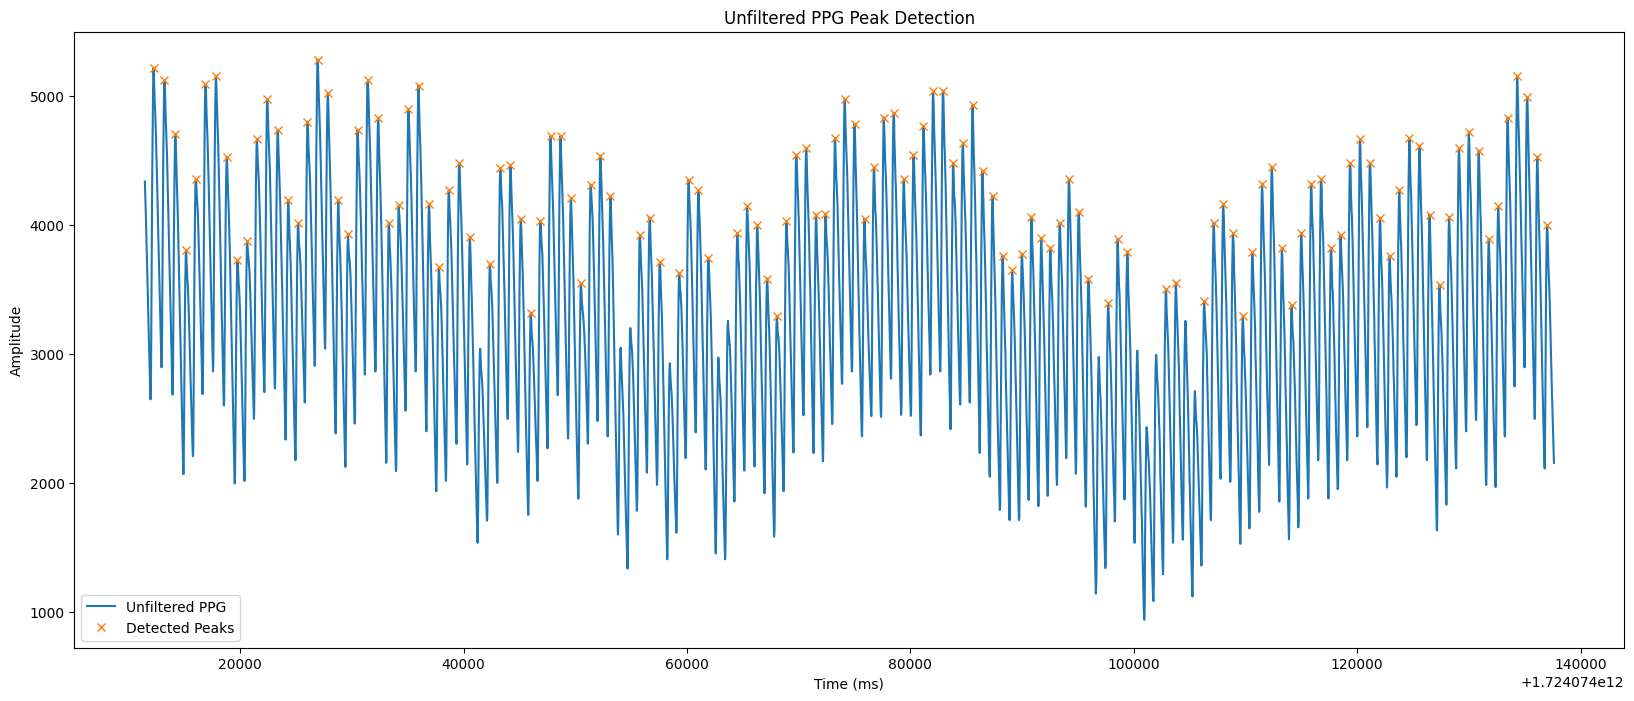

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(timestamps, ppg_raw, label="Unfiltered PPG")
plt.plot(timestamps[peaks], ppg_raw[peaks], 'x', label="Detected Peaks")
plt.title("Unfiltered PPG Peak Detection")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### **Number Of Peaks Detected in the _UNFILTERED_ PPG Data**

In [7]:
print(f"Detected {len(peaks)} peaks in the Unfiltered PPG")

Detected 130 peaks in the Unfiltered PPG


### **RRIs or IBIs (milliseconds) in _UNFILTERED_ PPG**

In [8]:
t_peaks = timestamps[peaks]
rri = np.diff(t_peaks)
print(rri)
print(np.mean(rri), np.max(rri), np.min(rri))
print(np.median(rri))

[ 975  974  975  855  875  935  974  955  854  895  914  935  954  877
  832  914  914  936  870  854  934  914  953  894  857  911  934  893
  874  934  953 1788  933  913  934  893  854  914  893  934  893  874
  873  894 2645  871  916 1724  836  891  872 2600  893  896  873  893
  850  873  893  873  853  860  872  871  892  830  893  893  899  866
  895  870  873  916  876  870  888  893  892  875  853  854  874  829
  839  824  860  885 1764  852  855 3459  903 2526  841  869  872  872
  869  861  866  906  877  852  885  905  887  859  846  892  871  921
  858  856  916  882  925  891  852  871  892  890  892  852  831  872
  890  911  892]
967.3255813953489 3459 824
890.0


### **Normal-to-Normal RR Intervals in _UNFILTERED_ PPG**

In [9]:
rri_normal = rri.copy()
mask1 = (rri_normal >= 300) & (rri_normal <= 2000)
rri_normal = rri_normal[mask1]

diffs = np.abs(np.diff(rri_normal))
mask2 = diffs <= 0.2 * rri_normal[:-1]
rri_normal = rri_normal[1:][mask2]
print(rri_normal)

[974 975 855 875 935 974 955 854 895 914 935 954 877 832 914 914 936 870
 854 934 914 953 894 857 911 934 893 874 934 953 913 934 893 854 914 893
 934 893 874 873 894 871 916 891 872 893 896 873 893 850 873 893 873 853
 860 872 871 892 830 893 893 899 866 895 870 873 916 876 870 888 893 892
 875 853 854 874 829 839 824 860 885 855 903 841 869 872 872 869 861 866
 906 877 852 885 905 887 859 846 892 871 921 858 856 916 882 925 891 852
 871 892 890 892 852 831 872 890 911 892]


### **SDNN (standard deviation of normal-to-normal RR-intervals) of _UNFILTERED_ PPG**
- After removing noise and non-sinus beats

In [10]:
sdnn = np.std(rri_normal, ddof=1)
print(sdnn)

32.053181082376796


### **SDRR (standard deviation of all RR-intervals) of _UNFILTERED_ PPG**
- Includes everything, including noise

In [11]:
sdrr = np.std(rri, ddof=1)
print(sdrr)

363.46314210467705


### **The RMSSD (Root Mean Square of Successive Differences) of _UNFILTERED_ PPG**

$$
\mathrm{RMSSD} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1} \bigl(RR_{i+1} - RR_i\bigr)^2}
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**

In [12]:
diff_rri = np.diff(rri)
rmmsd = np.sqrt(np.mean(diff_rri ** 2))
print(rmmsd)

526.8063196635933


### **The pNN50 (percentage of successive RR-interval differences greater than 50 ms) of _UNFILTERED_ PPG**

$$
\mathrm{pNN50} = \frac{\displaystyle\sum_{i=1}^{N-1} \mathbb{I}\bigl(\lvert RR_{i+1} - RR_{i}\rvert > 50\text{ ms}\bigr)}{N - 1} \times 100\%
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**
- **1 if condition is True, 0 otherwise**

In [13]:
pnn50 = (np.sum(np.abs(diff_rri) > 50) / len(diff_rri)) * 100
print(pnn50)

23.4375


### **HR Max, HR Min and HR Range of _UNFILTERED_ PPG**

In [14]:
hr = 60000 / rri
hr_range = np.max(hr) - np.min(hr)
print(hr.max())
print(hr.min())
print(hr_range)

72.81553398058253
17.346053772766695
55.469480207815835
